<a href="https://colab.research.google.com/github/geoffcorvera/cnn/blob/colab/catdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import os
import numpy as np 
from tensorflow.keras.applications import InceptionResNetV2
from keras import models
from keras import layers
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing as preprocessing_layers
from tensorflow.math import confusion_matrix

In [ ]:
# Confirm GPU connection
import tensorflow as tf 

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Import InceptionResNetV2 pre-trained model. A final binary classifier will be added to the top of this model.

In [ ]:
# Load resnet pretrained on ImageNet
pre_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
pre_model.trainable = False

219062272/219055592 [==============================] - 6s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

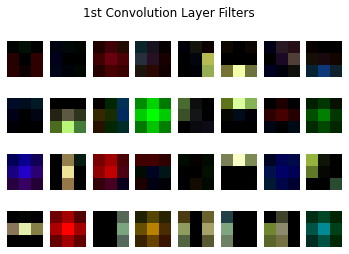

In [ ]:
import matplotlib.pyplot as plt

# Visualize inception resnet first layer filters
def getConvLayer(model):
  res = None
  for layer in model.layers:
    if 'conv' in layer.name:
      res = layer
      break
  return res

def visualizeFilters(filters):
  # filters = filters[0]
  nf = filters.shape[3]
  fig, _ = plt.subplots(4,8)
  
  for i, ax in enumerate(fig.axes):
    ax.imshow(filters[:,:,:,i])
    ax.set_axis_off()
  fig.suptitle('1st Convolution Layer Filters')
  plt.show()


conv_layer = getConvLayer(pre_model)
filters = conv_layer.get_weights()
visualizeFilters(conv_layer.get_weights()[0])

# Build Model
A binary classifier is added to the pre-trained model. The model also specifies preprocessing so it can take raw image data. Data is augmented with horizontal flips, random rotation and zooming. Pixel values are rescaled to range [0,1].

The model is compiled with binary cross entropy loss and RMSprop optimizer.

In [ ]:
print('Building model...\n')

data_augmentation = keras.Sequential(
    [
      preprocessing_layers.RandomFlip('horizontal'),
      preprocessing_layers.RandomRotation(0.1),
      preprocessing_layers.RandomZoom(0.1),
    ]
)

input_shape = (150,150,3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)           #Augment data to increase training set
x = preprocessing_layers.Rescaling(1.0/255)(x) #Rescale image values to [0,1]

outputs = pre_model(x)
outputs = layers.Flatten()(outputs) #flatten output of pre_model
outputs = layers.Dense(256, activation='relu')(outputs) #adds dense layer w/ 256 neurons + ReLU activation
outputs = layers.Dense(1, activation='sigmoid')(outputs) #output layer w/ single neuron, output in range [0,1]

model = keras.Model(inputs, outputs)

model.compile(optimizer='rmsprop',
              metrics=['accuracy'],
              loss='binary_crossentropy')

model.summary()

Building model...

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3539200   
_________________________________________________________________
dense_1 (Dense)              (None, 1)    

# Import Data
All images are resized to (150x150). The training dataset is split into training & validation datasets. Most of the preprocessing is specified within the model (see above).

In [ ]:
import tensorflow.keras.preprocessing as preprocessing
from google.colab import drive

print('Importing training and test datasets...\n')
batch_size = 64

train_path = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/p3_data/cats_dogs_dataset/dataset/training_set'
all_ds = preprocessing.image_dataset_from_directory(train_path,
                                                    image_size=(150,150),
                                                    shuffle=True,
                                                    label_mode='binary',
                                                    batch_size=batch_size)

val_size = 12
val_ds = all_ds.take(val_size)
train_ds = all_ds.skip(val_size)
# train_ds = train_ds.shuffle(buffer_size=1024).batch(64)

test_path = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/p3_data/cats_dogs_dataset/dataset/test_set'
test_ds = preprocessing.image_dataset_from_directory(test_path,
                                                     image_size=(150,150),
                                                     label_mode='binary',
                                                     batch_size=batch_size)


Importing training and test datasets...

Found 8282 files belonging to 2 classes.
Found 2003 files belonging to 2 classes.


# Train
The model is compiled with RMSprop optimizer and binary cross-entropy loss function.

Training continues for 3 epochs, with 0.2% of the training set used for validation to check generalization.

Weights are saved periodically during training to the "training" directory. When model fitting is complete, the model is saved to "last_trained" directory for future use.

In [ ]:
# Load pre-trained model and SKIP NEXT CODE BLOCK
model = keras.models.load_model(r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/saved_models/v4_catdog_binaryaccuracy')

In [ ]:
# fit model & save weights during training & after
checkpoint_path = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


print('Fitting to data...\n')
history = model.fit(train_ds,
                    epochs=5,
                    callbacks=[cp_callback],
                    validation_data=val_ds)

save_path = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/last_trained'
model.save(save_path)

Fitting to data...

Epoch 1/5
118/118 [==============================] - 2117s 16s/step - loss: 4.1973 - accuracy: 0.8630 - val_loss: 0.7033 - val_accuracy: 0.8906

Epoch 00001: saving model to /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training
Epoch 2/5
118/118 [==============================] - 789s 7s/step - loss: 0.4829 - accuracy: 0.9201 - val_loss: 0.1295 - val_accuracy: 0.9609

Epoch 00002: saving model to /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training
Epoch 3/5
118/118 [==============================] - 803s 7s/step - loss: 0.2926 - accuracy: 0.9261 - val_loss: 0.3545 - val_accuracy: 0.8945

Epoch 00003: saving model to /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training
Epoch 4/5
118/118 [==============================] - 813s 7s/step - loss: 0.2330 - accuracy: 0.9359 - val_loss: 0.2514 - val_accuracy: 0.9310

Epoch 00004: saving model to /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision

In [ ]:
# get sample from training set for sanity check
def get_preds_labels(dat):
  truths = []
  preds = []
  for X,Y in dat:
    truths.append(Y.numpy().astype(int))
    preds.append(model.predict(X))

  preds = np.concatenate(preds, axis=0)
  truths = np.concatenate(truths, axis=0)
  print(preds.shape, truths.shape)
  # Threshold at 0.9
  preds = np.where(preds>0.9,1,0).astype(int)

  return (preds, truths)

def show_conf_mat(Y, labels):
  # Show confusion matrix
  con_mat = confusion_matrix(labels=Y, predictions=labels).numpy()
  plt.matshow(con_mat)
  plt.show()
  

print('Evaluating against test set...')
# results = model.evaluate(test_ds)

print('Running predictions on test set...')
preds, truths = get_preds_labels(test_ds)
show_conf_mat(preds.reshape(-1), truths.reshape(-1))


Evaluating against test set...
Running predictions on test set...
